In [1]:
import torch
import torchvision
from torchvision import transforms
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.input_dim = input_dim  # Store the input dimension
        self.main = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)/2 + 0.5


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


In [4]:
latent_dims = [2, 4, 8, 16, 32, 64]
models = {dim: Generator(input_dim=dim) for dim in latent_dims}


In [5]:
criterion = nn.BCELoss()
optimizers = {dim: {'generator': optim.Adam(models[dim].parameters(), lr=0.0002, betas=(0.5, 0.999)),
                    'discriminator': optim.Adam(Discriminator().parameters(), lr=0.0002, betas=(0.5, 0.999))}
              for dim in latent_dims}
discriminators = {dim: Discriminator() for dim in latent_dims}


In [6]:
def train_gan(generator, discriminator, optimizer_g, optimizer_d, trainloader, criterion, device, epochs=50):
    for epoch in range(epochs):
        for i, (images, _) in enumerate(trainloader):
            batch_size = images.size(0)
            real_images = images.to(device)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            discriminator.zero_grad()
            real_loss = criterion(discriminator(real_images), real_labels)
            z = torch.randn(batch_size, generator.input_dim).to(device)
            fake_images = generator(z)
            fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            generator.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_g.step()

            if (i + 1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')
def visualize(generator, input_dim, examples=5, fig_size=(10, 2)):
    z = torch.randn(examples, input_dim).to(device)
    generator.eval()
    with torch.no_grad():
        fake_images = generator(z).view(-1, 1, 28, 28)
    plt.figure(figsize=fig_size)
    for i in range(examples):
        plt.subplot(1, examples, i + 1)
        plt.imshow(fake_images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()
    generator.train()


Training GAN with latent dimension: 2
Epoch [1/20], Step [500/938], D Loss: 0.8701, G Loss: 1.7103
Epoch [2/20], Step [500/938], D Loss: 0.8802, G Loss: 1.6045
Epoch [3/20], Step [500/938], D Loss: 0.8791, G Loss: 1.7318
Epoch [4/20], Step [500/938], D Loss: 0.7219, G Loss: 1.5578
Epoch [5/20], Step [500/938], D Loss: 0.7960, G Loss: 1.9769
Epoch [6/20], Step [500/938], D Loss: 0.5733, G Loss: 2.0447
Epoch [7/20], Step [500/938], D Loss: 1.0496, G Loss: 2.0882
Epoch [8/20], Step [500/938], D Loss: 0.5201, G Loss: 2.2046
Epoch [9/20], Step [500/938], D Loss: 0.6233, G Loss: 1.8748
Epoch [10/20], Step [500/938], D Loss: 0.6375, G Loss: 2.1197
Epoch [11/20], Step [500/938], D Loss: 0.6108, G Loss: 1.8548
Epoch [12/20], Step [500/938], D Loss: 0.8810, G Loss: 1.9754
Epoch [13/20], Step [500/938], D Loss: 0.7634, G Loss: 1.8967
Epoch [14/20], Step [500/938], D Loss: 0.7800, G Loss: 1.7646
Epoch [15/20], Step [500/938], D Loss: 0.7772, G Loss: 1.6167
Epoch [16/20], Step [500/938], D Loss: 0.

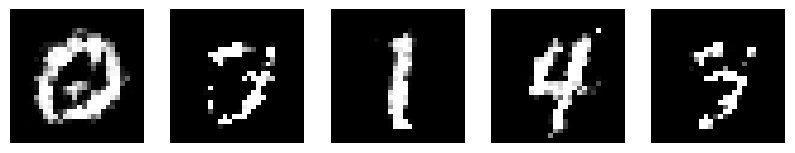

Training GAN with latent dimension: 4
Epoch [1/20], Step [500/938], D Loss: 0.7626, G Loss: 2.3050
Epoch [2/20], Step [500/938], D Loss: 0.8195, G Loss: 1.8493
Epoch [3/20], Step [500/938], D Loss: 0.9565, G Loss: 1.2691
Epoch [4/20], Step [500/938], D Loss: 0.9850, G Loss: 1.1856
Epoch [5/20], Step [500/938], D Loss: 0.9495, G Loss: 1.4179
Epoch [6/20], Step [500/938], D Loss: 1.1228, G Loss: 1.1955
Epoch [7/20], Step [500/938], D Loss: 1.0620, G Loss: 1.0982
Epoch [8/20], Step [500/938], D Loss: 0.9442, G Loss: 1.2599
Epoch [9/20], Step [500/938], D Loss: 1.0734, G Loss: 1.2834
Epoch [10/20], Step [500/938], D Loss: 1.0280, G Loss: 1.1049
Epoch [11/20], Step [500/938], D Loss: 1.1113, G Loss: 1.1616
Epoch [12/20], Step [500/938], D Loss: 1.1306, G Loss: 1.0803
Epoch [13/20], Step [500/938], D Loss: 1.0824, G Loss: 1.1868
Epoch [14/20], Step [500/938], D Loss: 1.2186, G Loss: 1.1092
Epoch [15/20], Step [500/938], D Loss: 1.2734, G Loss: 1.0030
Epoch [16/20], Step [500/938], D Loss: 1.

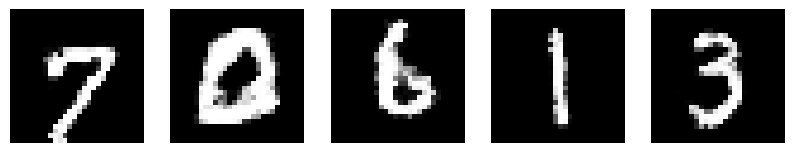

Training GAN with latent dimension: 8
Epoch [1/20], Step [500/938], D Loss: 0.8201, G Loss: 2.6955
Epoch [2/20], Step [500/938], D Loss: 0.8856, G Loss: 1.8795
Epoch [3/20], Step [500/938], D Loss: 1.0027, G Loss: 1.3257
Epoch [4/20], Step [500/938], D Loss: 0.9300, G Loss: 1.4134
Epoch [5/20], Step [500/938], D Loss: 1.1759, G Loss: 1.1786
Epoch [6/20], Step [500/938], D Loss: 1.1862, G Loss: 1.0338
Epoch [7/20], Step [500/938], D Loss: 1.1827, G Loss: 1.1270
Epoch [8/20], Step [500/938], D Loss: 1.1454, G Loss: 1.0765
Epoch [9/20], Step [500/938], D Loss: 1.2691, G Loss: 0.9568
Epoch [10/20], Step [500/938], D Loss: 1.1531, G Loss: 1.1152
Epoch [11/20], Step [500/938], D Loss: 1.2918, G Loss: 0.9154
Epoch [12/20], Step [500/938], D Loss: 1.2148, G Loss: 0.8295
Epoch [13/20], Step [500/938], D Loss: 1.2339, G Loss: 0.9731
Epoch [14/20], Step [500/938], D Loss: 1.2192, G Loss: 0.8705
Epoch [15/20], Step [500/938], D Loss: 1.2326, G Loss: 0.9988
Epoch [16/20], Step [500/938], D Loss: 1.

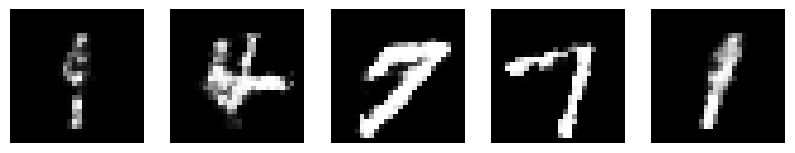

Training GAN with latent dimension: 16
Epoch [1/20], Step [500/938], D Loss: 0.7198, G Loss: 2.5688
Epoch [2/20], Step [500/938], D Loss: 0.7425, G Loss: 2.0109
Epoch [3/20], Step [500/938], D Loss: 0.7950, G Loss: 1.8574
Epoch [4/20], Step [500/938], D Loss: 1.0144, G Loss: 1.4748
Epoch [5/20], Step [500/938], D Loss: 1.0194, G Loss: 1.2374
Epoch [6/20], Step [500/938], D Loss: 1.0834, G Loss: 1.2145
Epoch [7/20], Step [500/938], D Loss: 1.2536, G Loss: 1.1099
Epoch [8/20], Step [500/938], D Loss: 1.1173, G Loss: 1.1829
Epoch [9/20], Step [500/938], D Loss: 1.1748, G Loss: 1.1672
Epoch [10/20], Step [500/938], D Loss: 1.3648, G Loss: 0.9865
Epoch [11/20], Step [500/938], D Loss: 1.2242, G Loss: 0.9602
Epoch [12/20], Step [500/938], D Loss: 1.1928, G Loss: 1.0207
Epoch [13/20], Step [500/938], D Loss: 1.2627, G Loss: 0.9437
Epoch [14/20], Step [500/938], D Loss: 1.1560, G Loss: 1.0316
Epoch [15/20], Step [500/938], D Loss: 1.2592, G Loss: 0.9961
Epoch [16/20], Step [500/938], D Loss: 1

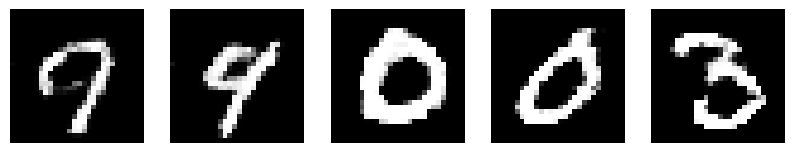

Training GAN with latent dimension: 32
Epoch [1/20], Step [500/938], D Loss: 0.6357, G Loss: 2.7318
Epoch [2/20], Step [500/938], D Loss: 0.6511, G Loss: 2.0730
Epoch [3/20], Step [500/938], D Loss: 0.8269, G Loss: 2.0300
Epoch [4/20], Step [500/938], D Loss: 0.9172, G Loss: 1.3902
Epoch [5/20], Step [500/938], D Loss: 1.0642, G Loss: 1.2157
Epoch [6/20], Step [500/938], D Loss: 1.0960, G Loss: 1.1608
Epoch [7/20], Step [500/938], D Loss: 1.1671, G Loss: 1.1719
Epoch [8/20], Step [500/938], D Loss: 1.0456, G Loss: 1.1631
Epoch [9/20], Step [500/938], D Loss: 1.0864, G Loss: 0.9971
Epoch [10/20], Step [500/938], D Loss: 1.1405, G Loss: 0.9502
Epoch [11/20], Step [500/938], D Loss: 1.1403, G Loss: 1.1044
Epoch [12/20], Step [500/938], D Loss: 1.2478, G Loss: 1.0067
Epoch [13/20], Step [500/938], D Loss: 1.2160, G Loss: 0.9752
Epoch [14/20], Step [500/938], D Loss: 1.2812, G Loss: 0.9856
Epoch [15/20], Step [500/938], D Loss: 1.2001, G Loss: 1.0266
Epoch [16/20], Step [500/938], D Loss: 1

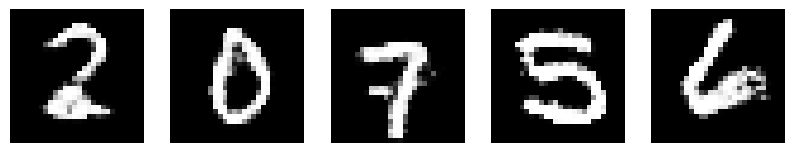

Training GAN with latent dimension: 64
Epoch [1/20], Step [500/938], D Loss: 0.5053, G Loss: 2.8660
Epoch [2/20], Step [500/938], D Loss: 0.5471, G Loss: 1.9433
Epoch [3/20], Step [500/938], D Loss: 0.7549, G Loss: 1.7537
Epoch [4/20], Step [500/938], D Loss: 0.9551, G Loss: 1.6774
Epoch [5/20], Step [500/938], D Loss: 1.0633, G Loss: 1.2839
Epoch [6/20], Step [500/938], D Loss: 1.0301, G Loss: 1.0719
Epoch [7/20], Step [500/938], D Loss: 1.0399, G Loss: 1.2384
Epoch [8/20], Step [500/938], D Loss: 1.1114, G Loss: 1.2175
Epoch [9/20], Step [500/938], D Loss: 1.1308, G Loss: 1.0371
Epoch [10/20], Step [500/938], D Loss: 1.1363, G Loss: 1.1334
Epoch [11/20], Step [500/938], D Loss: 1.1983, G Loss: 1.0401
Epoch [12/20], Step [500/938], D Loss: 1.1006, G Loss: 1.0561
Epoch [13/20], Step [500/938], D Loss: 1.1054, G Loss: 1.3164
Epoch [14/20], Step [500/938], D Loss: 1.2807, G Loss: 0.8789
Epoch [15/20], Step [500/938], D Loss: 1.1299, G Loss: 0.9143
Epoch [16/20], Step [500/938], D Loss: 1

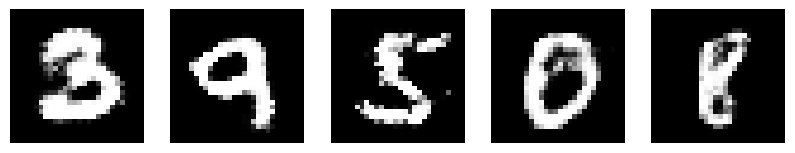

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for dim in latent_dims:
    print(f"Training GAN with latent dimension: {dim}")
    generator = Generator(input_dim=dim).to(device)
    discriminator = Discriminator().to(device)

    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    train_gan(generator, discriminator, optimizer_g, optimizer_d, trainloader, criterion, device, epochs=20)

    print(f"Visualizing results for latent dimension: {dim}")
    visualize(generator, dim)
